In [2]:
import numpy as np
import os
import pandas as pd
import h5py
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [4]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [5]:
# set random seed for reproducibility
set_random_seed(seed=42)

2026-01-18 13:21:27.300017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2026-01-18 13:21:27.300040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Prep atac_hgp_map for hv2 to run on encode k562

I took this from 12_21_2025.ipynb.

Ran /home/valehvpa/projects/scCisTrans/histobpnet/experiments/valeh/scripts/narrowPeaks_to_summits_modified.sh to generate summits bed file for the correct peak set (peaks.all_input_regions.ENCSR868FGK.bed.gz).

Also ran this manually first as bedtools closest needs files to be lexicographically sorted according to their webapge and chatgpt.
Note here Im using the narrow peaks from encode directly, not peaks.bed from anusri, im not exactly sure what the difference is but hopefully it doesnt matter a lot for now.

In [ ]:
# zcat /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.bed.gz | sort -k1,1 -k2,2n -c
# -> didnt return 0, so I re sorted using the below

In [ ]:
# gunzip -k /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.bed.gz

# sort -k1,1 -k2,2n /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.bed > \
#     /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.sorted.lexicographic.bed

In [ ]:
# sort -k1,1 -k2,2n -c /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.sorted.lexicographic.bed
# echo $?
# > ran this to make sure the first command returns nothing and the second returns 0 (meaning the file is sorted)

In [8]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.sorted.lexicographic.bed"

histone_df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
histone_df["length"] = histone_df[2] - histone_df[1]
histone_df.rename(columns={0: 'chrom', 1: 'chromStart', 2: 'chromEnd'}, inplace=True)

assert histone_df.duplicated().any() == False, "There are duplicate rows in the histone peaks file."
print(histone_df.shape)

(54625, 11)


In [9]:
def run_closest_for_window_reverse(window: int, base_dir_override: str, atac_bed = None):
    print("*** Running for window size: ", window)

    # read atac peaks, keep only chrom, chromStart, chromEnd
    atac_df = pl.read_csv(
        atac_bed,
        separator="\t",
        has_header=False,
        new_columns=[
            "chrom", "chromStart", "chromEnd", "name", "score", "strand",
        ],
    ).select(["chrom", "chromStart", "chromEnd"])

    # select cols
    pl.from_pandas(histone_df).select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_B.bed"),
        separator="\t",
        include_header=False
    )
    atac_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_A.bed"),
        separator="\t",
        include_header=False
    )

    # https://bedtools.readthedocs.io/en/latest/content/tools/closest.html
    fn_prefix = f"reverse_narrow_peak_histone_closest_{str(window)}bp"
    # -t first returns the "first" closest feature in B in case of ties
    cmd = f"cd {base_dir_override} && \
        bedtools closest -a temp_A.bed -b temp_B.bed -t first > {fn_prefix}_atac.bed && \
        command rm -rf temp_A.bed && \
        command rm -rf temp_B.bed"
    os.system(cmd)

In [10]:
bdo = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed"
run_closest_for_window_reverse(
    2114,
    base_dir_override=bdo,
    atac_bed=os.path.join(bdo, "peaks.all_input_regions.ENCSR868FGK.summits.2114bp.sorted.lexicographic.bed.gz"),
)

*** Running for window size:  2114


In [11]:
!head /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed/reverse_narrow_peak_histone_closest_2114bp_atac.bed

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
chr1	39778	41892	chr1	118751	119101
chr1	40034	42148	chr1	118751	119101
chr1	40545	42659	chr1	118751	119101
chr1	41223	43337	chr1	118751	119101
chr1	45439	47553	chr1	118751	119101
chr1	45861	47975	chr1	118751	119101
chr1	66671	68785	chr1	118751	119101
chr1	67140	69254	chr1	118751	119101
chr1	68021	70135	chr1	118751	119101
chr1	68231	70345	chr1	118751	119101


The two counts below should be teh same (ie number of atac peaks is unchanged after bedtools closest)

In [12]:
!zcat /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed/peaks.all_input_regions.ENCSR868FGK.summits.2114bp.sorted.lexicographic.bed.gz | wc -l

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
269718


In [13]:
!wc -l /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed/reverse_narrow_peak_histone_closest_2114bp_atac.bed

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
269718 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed/reverse_narrow_peak_histone_closest_2114bp_atac.bed


In [14]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed/reverse_narrow_peak_histone_closest_2114bp_atac.bed"
df = pd.read_csv(p, sep="\t", header=None, names=["chrom_atac", "start_atac", "end_atac", "chrom_histone", "start_histone", "end_histone"])
df

,chrom_atac,start_atac,end_atac,chrom_histone,start_histone,end_histone
0,chr1,39778,41892,chr1,118751,119101
1,chr1,40034,42148,chr1,118751,119101
2,chr1,40545,42659,chr1,118751,119101
3,chr1,41223,43337,chr1,118751,119101
4,chr1,45439,47553,chr1,118751,119101
...,...,...,...,...,...,...
269713,chrY,11097555,11099669,.,-1,-1
269714,chrY,11102145,11104259,.,-1,-1
269715,chrY,12393985,12396099,.,-1,-1
269716,chrY,12394138,12396252,.,-1,-1


In [15]:
df[df["chrom_histone"] == "."]

,chrom_atac,start_atac,end_atac,chrom_histone,start_histone,end_histone
269710,chrY,4029866,4031980,.,-1,-1
269711,chrY,11096707,11098821,.,-1,-1
269712,chrY,11097358,11099472,.,-1,-1
269713,chrY,11097555,11099669,.,-1,-1
269714,chrY,11102145,11104259,.,-1,-1
269715,chrY,12393985,12396099,.,-1,-1
269716,chrY,12394138,12396252,.,-1,-1
269717,chrY,18991874,18993988,.,-1,-1


## constrain to 1k distance

skip the atac peaks who are not within Xbp of the hgp (in the sense coded below). Adn for those I set hist_chrom to -1 so that in the code after setting skip_missing_hist these will be effectively skipped.

In [16]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed/reverse_narrow_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])

In [17]:
# if end is < hist_start - 2000, or start > hist_end + 2000, then set out_of_bounds to True
X = 2000
atac_hgp_df["out_of_bounds"] = (atac_hgp_df["end"] < atac_hgp_df["hist_start"] - X) | (atac_hgp_df["start"] > atac_hgp_df["hist_end"] + X)
# if hist_chrom is ".", then also set out_of_bounds to True
atac_hgp_df.loc[atac_hgp_df["hist_chrom"] == ".", "out_of_bounds"] = True
atac_hgp_df["out_of_bounds"].sum() * 100 / len(atac_hgp_df)

53.62007726588511

In [18]:
# if end is < hist_start - 1000, or start > hist_end + 1000, then set out_of_bounds to True
X = 1000
atac_hgp_df["out_of_bounds"] = (atac_hgp_df["end"] < atac_hgp_df["hist_start"] - X) | (atac_hgp_df["start"] > atac_hgp_df["hist_end"] + X)
# if hist_chrom is ".", then also set out_of_bounds to True
atac_hgp_df.loc[atac_hgp_df["hist_chrom"] == ".", "out_of_bounds"] = True
atac_hgp_df["out_of_bounds"].sum() * 100 / len(atac_hgp_df)

55.05639223188664

In [19]:
idx = atac_hgp_df["out_of_bounds"] == True
atac_hgp_df.loc[idx, "hist_chrom"] = "."
atac_hgp_df.loc[idx, "hist_start"] = "-1"
atac_hgp_df.loc[idx, "hist_end"] = "-1"
# set dtype to int
atac_hgp_df["hist_start"] = atac_hgp_df["hist_start"].astype(int)
atac_hgp_df["hist_end"] = atac_hgp_df["hist_end"].astype(int)
del atac_hgp_df["out_of_bounds"]

/tmp/ipykernel_1567097/316362100.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  atac_hgp_df.loc[idx, "hist_start"] = "-1"
/tmp/ipykernel_1567097/316362100.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  atac_hgp_df.loc[idx, "hist_end"] = "-1"


In [20]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/k562_atac_encode/processed/reverse_gapped_peak_histone_closest_2114bp_atac_within_1k_bound.bed"
atac_hgp_df.to_csv(
    p,
    sep="\t",
    header=False,
    index=False
)

## make from_anusri/pooled.bw from from_anusri/plus.bw and from_anusri/minus.bw

I ended up running process_encode_chip.sh to re-create bigwigs from encode bam files such that I can create unstranded (pooled) bigwigs direclty from bam files...
Btw the resulting bw files (plus and minus bw) dont have the same checksum as anusri's files. Idk exactly what's different. But just as a sanity check let s plot the chip/count correlation for these.

In [6]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.bed"
chip = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/pooled.bw"
inputc = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/control_pooled.bw"

df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
df["length"] = df[2] - df[1]
df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

import pyBigWig
chip_bw = pyBigWig.open(chip)
inputc_bw = pyBigWig.open(inputc)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['chrom'],
                                    r['start'],
                                    r['end']))
            ]))

    return vals

chip_cts = get_cts(df, chip_bw, None, get_total_cts=True)
inputc_cts = get_cts(df, inputc_bw, None, get_total_cts=True)

chip_cts = np.array([v[0] for v in chip_cts]).squeeze()
inputc_cts = np.array([v[0] for v in inputc_cts]).squeeze()

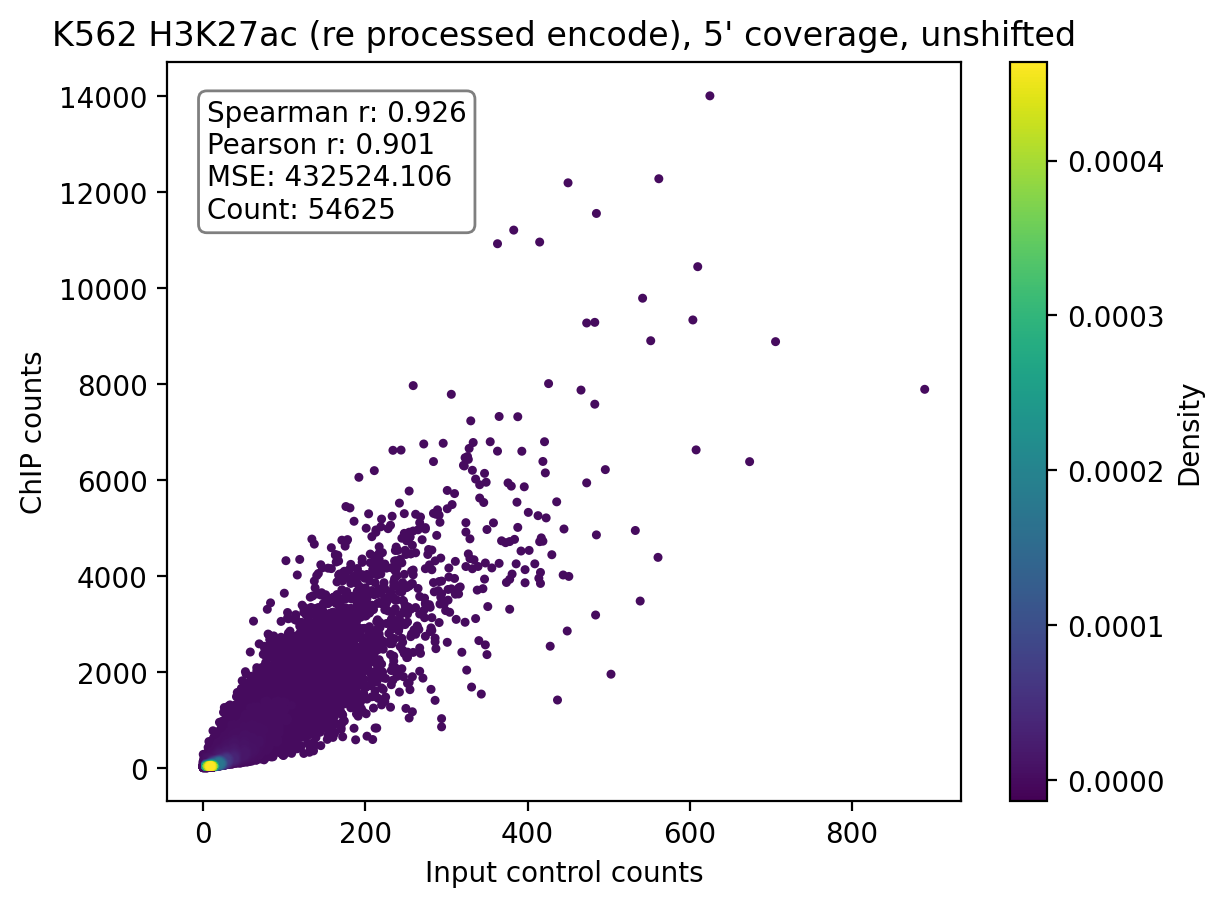

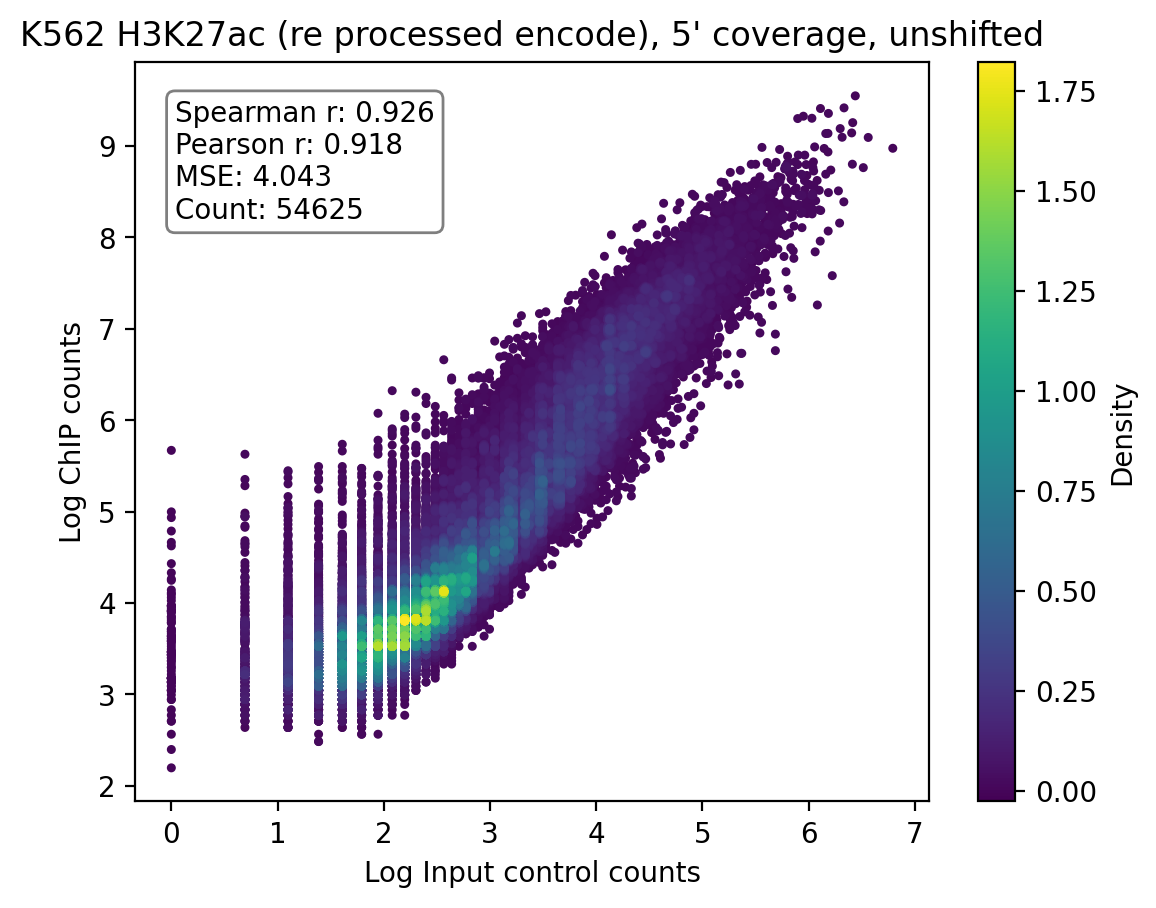

In [9]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 H3K27ac (re processed encode), 5' coverage, unshifted")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 H3K27ac (re processed encode), 5' coverage, unshifted")
plt.show()

Ok so it doesnt match anusri's, the correlation is higher here, and the input counts and chip counts are somewhat lower (See my deck)... Anyway, I'm just going to use her dataset for now

Same as above but with anusri s peaks

In [11]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/from_anusri/peaks.bed"
chip = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/pooled.bw"
inputc = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/control_pooled.bw"

df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
df["length"] = df[2] - df[1]
df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

import pyBigWig
chip_bw = pyBigWig.open(chip)
inputc_bw = pyBigWig.open(inputc)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['chrom'],
                                    r['start'],
                                    r['end']))
            ]))

    return vals

chip_cts = get_cts(df, chip_bw, None, get_total_cts=True)
inputc_cts = get_cts(df, inputc_bw, None, get_total_cts=True)

chip_cts = np.array([v[0] for v in chip_cts]).squeeze()
inputc_cts = np.array([v[0] for v in inputc_cts]).squeeze()

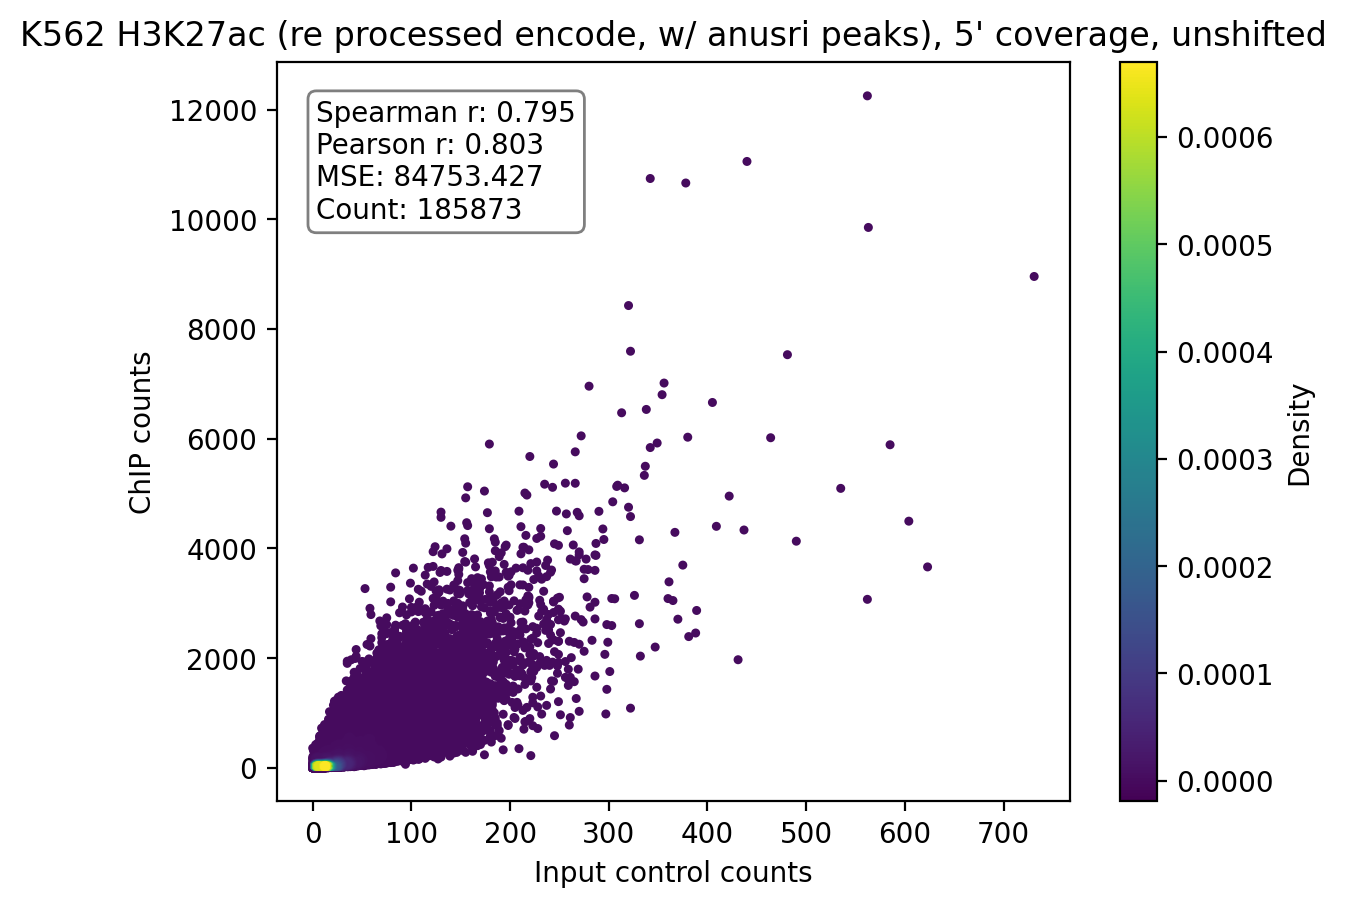

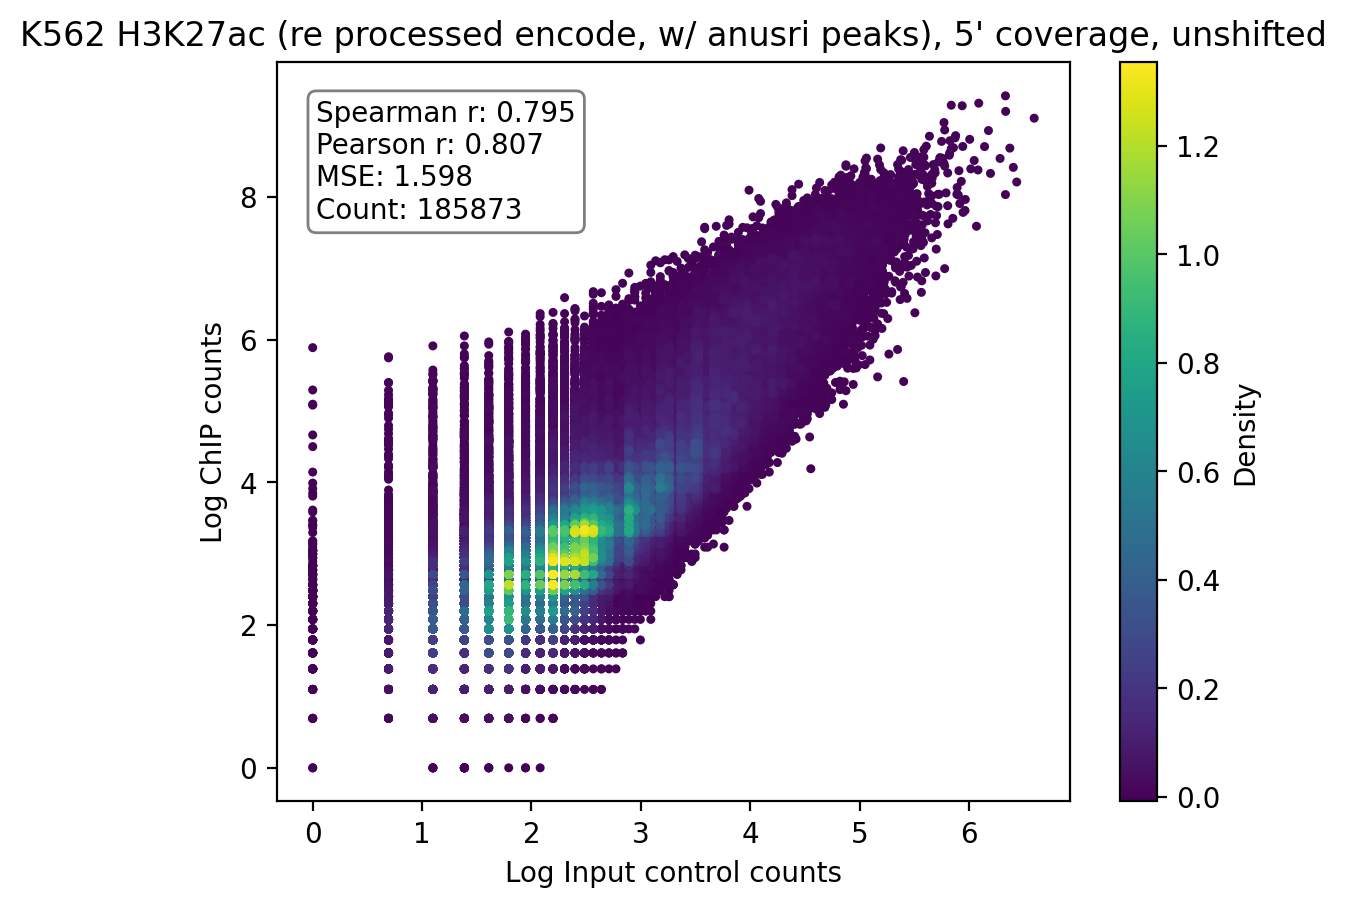

In [12]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 H3K27ac (re processed encode, w/ anusri peaks), 5' coverage, unshifted")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 H3K27ac (re processed encode, w/ anusri peaks), 5' coverage, unshifted")
plt.show()

Ok so changing the peaks reduces the correlation.. I have no idea why or what these peaks are...

Re run but with plus and minus, this is a sanity check, it should match almost exaclty the pooled version from earlier.

In [13]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/ENCFF544LXB.bed.gz"
inputc_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/control_minus.bw"
inputc_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/control_plus.bw"
chip_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/minus.bw"
chip_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_h3k27ac/processed/plus.bw"

df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
df["length"] = df[2] - df[1]
df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

import pyBigWig
chip_minus_bw = pyBigWig.open(chip_minus)
chip_plus_bw = pyBigWig.open(chip_plus)
inputc_minus_bw = pyBigWig.open(inputc_minus)
inputc_plus_bw = pyBigWig.open(inputc_plus)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['chrom'],
                                    r['start'],
                                    r['end']))
            ]))

    return vals

chip_minus_cts = get_cts(df, chip_minus_bw, None, get_total_cts=True)
chip_plus_cts = get_cts(df, chip_plus_bw, None, get_total_cts=True)
inputc_minus_cts = get_cts(df, inputc_minus_bw, None, get_total_cts=True)
inputc_plus_cts = get_cts(df, inputc_plus_bw, None, get_total_cts=True)

chip_minus_cts = np.array([v[0] for v in chip_minus_cts]).squeeze()
chip_plus_cts = np.array([v[0] for v in chip_plus_cts]).squeeze()
inputc_minus_cts = np.array([v[0] for v in inputc_minus_cts]).squeeze()
inputc_plus_cts = np.array([v[0] for v in inputc_plus_cts]).squeeze()

# pool
chip_cts = chip_minus_cts + chip_plus_cts
inputc_cts = inputc_minus_cts + inputc_plus_cts

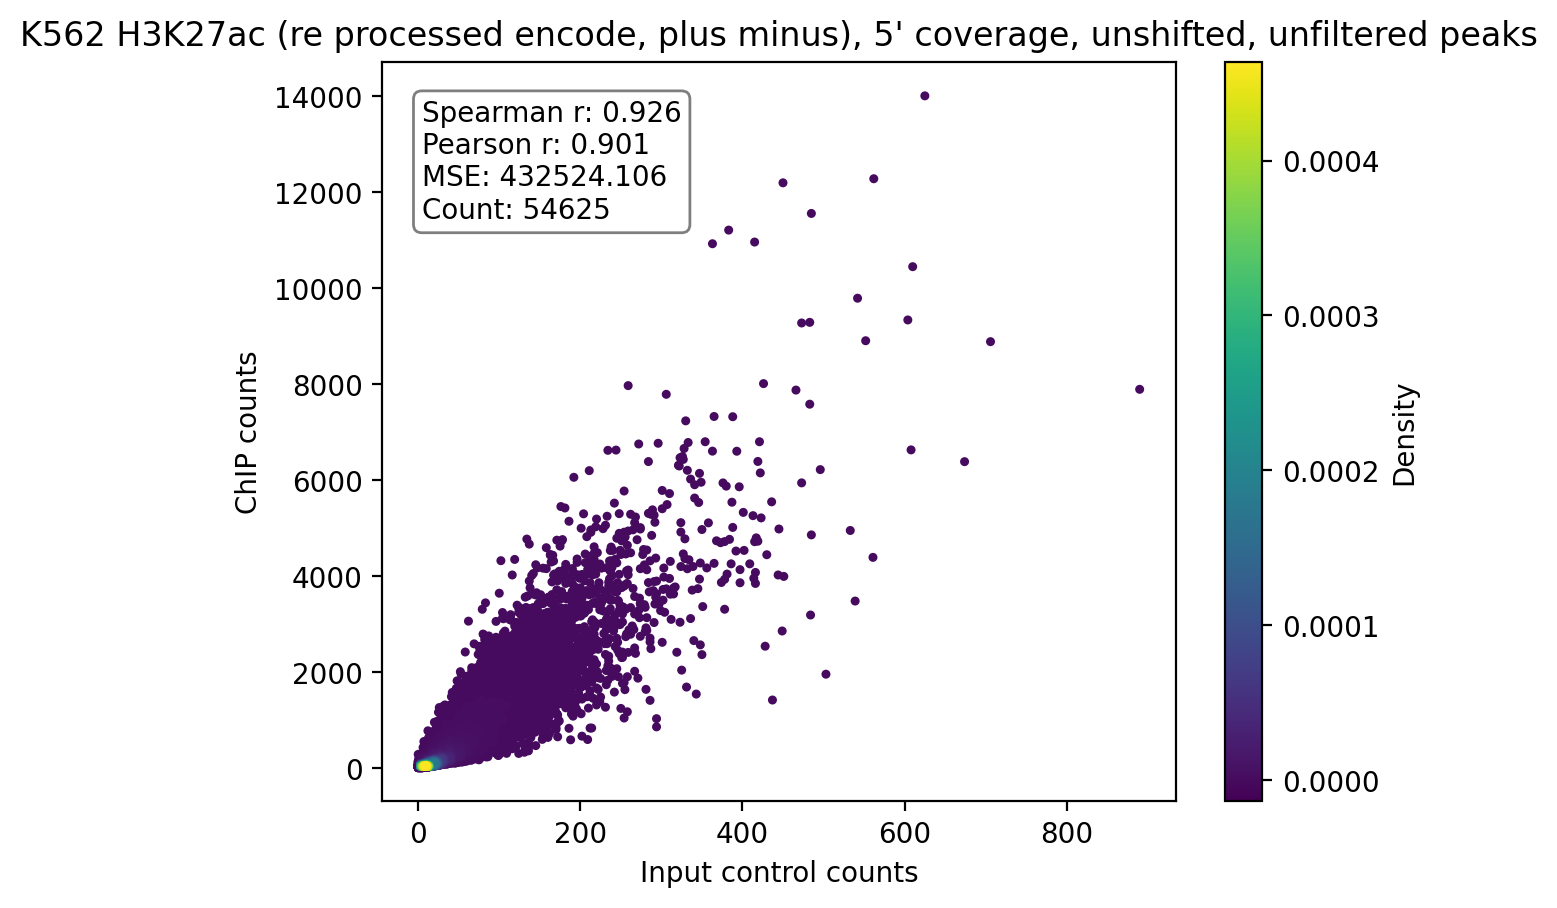

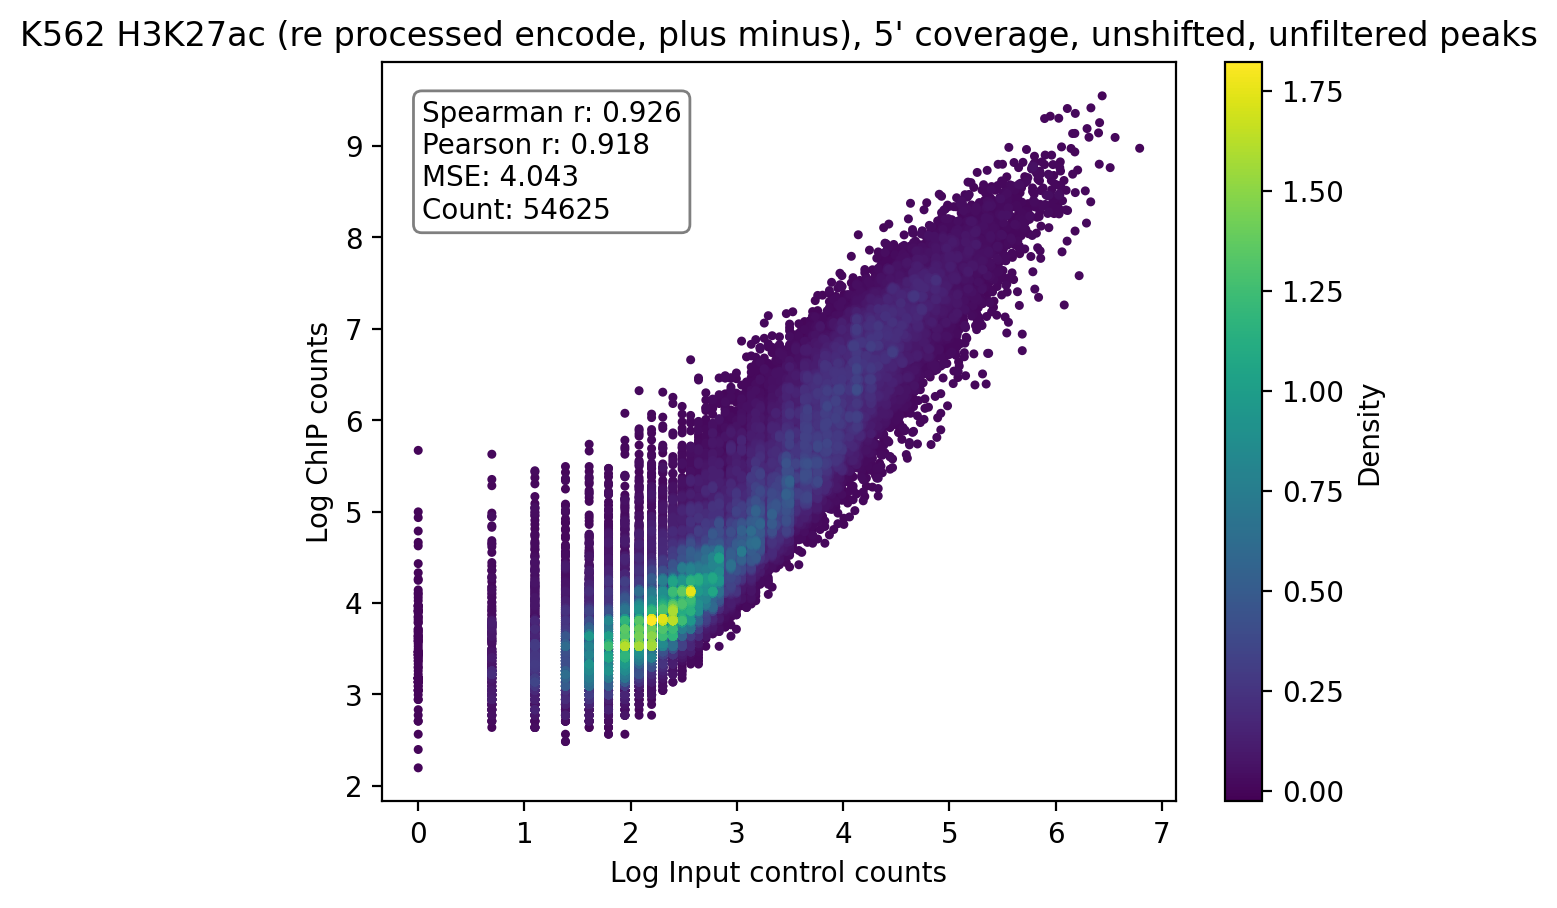

In [14]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 H3K27ac (re processed encode, plus minus), 5' coverage, unshifted, unfiltered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 H3K27ac (re processed encode, plus minus), 5' coverage, unshifted, unfiltered peaks")
plt.show()

yes it does exactly match, good